데이콘 중고차 가격 예측 : https://dacon.io/competitions/official/235901/overview/description



## 필수 라이브러리

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
from tqdm import tqdm

## 데이터 불러오기


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
cd '/content/gdrive/My Drive/dataset/used_car_price/'

/content/gdrive/My Drive/dataset/used_car_price


In [4]:
!unzip -qq data.zip

In [5]:
!ls

data.zip  sample_submission.csv  test.csv  train.csv


## 데이터 살펴보기

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [9]:
train.head()

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000
3,3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,3815000
4,4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,7385000


In [10]:
test.head()

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year
0,0,Mercedes-Benz C 300,1234,Abuja,New,4-cylinder(I4),automatic,petrol,White,2017
1,1,Honda Accord,29938,Abuja,Foreign Used,4-cylinder(I4),automatic,petrol,White,2013
2,2,Mercedes-Benz S 550,87501,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Black,2012
3,3,Toyota Sienna,180894,Lagos,Locally used,6-cylinder(V6),automatic,petrol,Dark Grey,2001
4,4,Toyota Hiace,104814,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,White,2000


In [11]:
print('train shape:', train.shape)
print('test shape:', test.shape)

train shape: (1015, 11)
test shape: (436, 10)


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015 entries, 0 to 1014
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1015 non-null   int64 
 1   title         1015 non-null   object
 2   odometer      1015 non-null   int64 
 3   location      1015 non-null   object
 4   isimported    1015 non-null   object
 5   engine        1015 non-null   object
 6   transmission  1015 non-null   object
 7   fuel          1015 non-null   object
 8   paint         1015 non-null   object
 9   year          1015 non-null   int64 
 10  target        1015 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 87.4+ KB


In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            436 non-null    int64 
 1   title         436 non-null    object
 2   odometer      436 non-null    int64 
 3   location      436 non-null    object
 4   isimported    436 non-null    object
 5   engine        436 non-null    object
 6   transmission  436 non-null    object
 7   fuel          436 non-null    object
 8   paint         436 non-null    object
 9   year          436 non-null    int64 
dtypes: int64(3), object(7)
memory usage: 34.2+ KB


## 중고차 가격(타겟값) 분석



### 데이터 분석
- 그래프를 봤을때 진짜 일부가 가격대가 매우 높은것을 알 수 있음
- 나머지는 다 고만고만한듯

<Figure size 1440x360 with 0 Axes>

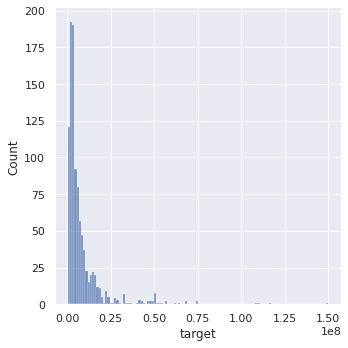

In [26]:
# 중고차 가격 분포도 - 왼쪽으로 쏠려있는 형태 주목
plt.figure(figsize = (20, 5))
sns.displot(train['target'])

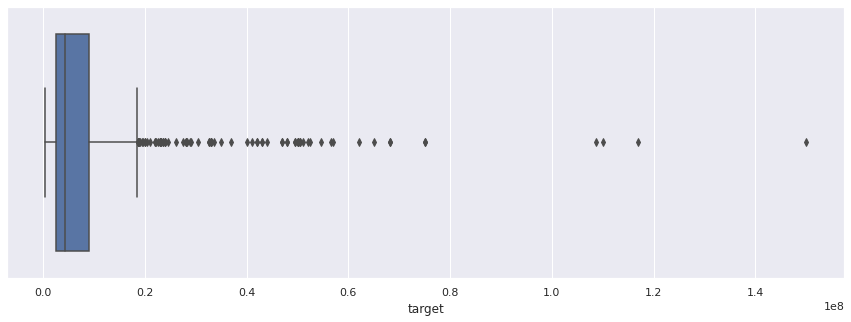

In [25]:
# 이상치가 분명하게 보임 - 근데 이걸 제거하는게 맞나싶기도하고...
# 진짜 어쩌다 한번씩 롤스로이드? 같은 차가 매물로 나올 수도 있는거고, 이상치를 제거해버리면 제대로 예측할 수 있을까?
# 근데 찾아보면 이상치 제거는 어쩔 수 없는거 같다.
plt.figure(figsize = (15, 5))
sns.boxplot(x=train['target'])

### 로그정규분포 적용

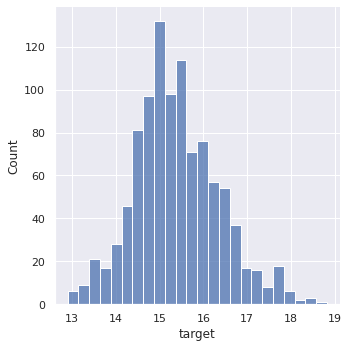

In [28]:
# 왼쪽으로 쏠려있으므로 로그정규분포 적용 - 아쉽게도 약간 치우쳐져 있음
target_log = np.log(train['target'])
sns.displot(target_log)

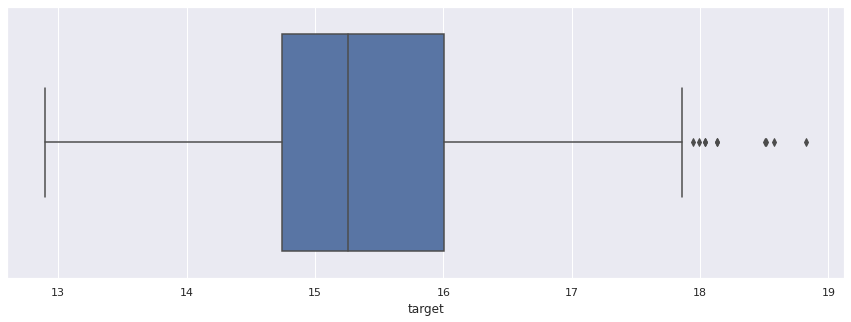

In [29]:
# 이상치를 제거해주자
plt.figure(figsize = (15, 5))
sns.boxplot(x=target_log)

### 이상치(Outlier) 제거

In [30]:
# Outlier인 데이터 제거하기

# 1분위수 계산
Q1 = target_log.quantile(0.25)
# 3분위수 계산
Q3 = target_log.quantile(0.75)

LB = Q1 - 1.5 * (Q3 - Q1) # 아래 수염
UB = Q3 + 1.5 * (Q3 - Q1) # 위 윗수염

outlier_mask = (target_log > UB) + (target_log < LB)
outliers = target_log[outlier_mask]
outliers

332    18.038908
341    18.577813
423    17.990129
432    18.038908
569    18.516127
597    18.826246
672    18.133199
736    18.504010
774    17.942887
827    18.133199
Name: target, dtype: float64

In [31]:
target_clean_mask = (target_log <= UB) * (target_log >= LB) # 수염 내부의 데이터에 대한 마스크만 가져옵니다.

target_clean = target_log[target_clean_mask]
target_clean

0       16.430348
1       17.312473
2       16.109559
3       15.154451
4       15.814961
          ...    
1010    15.504683
1011    15.100602
1012    15.043688
1013    16.476818
1014    16.119595
Name: target, Length: 1005, dtype: float64

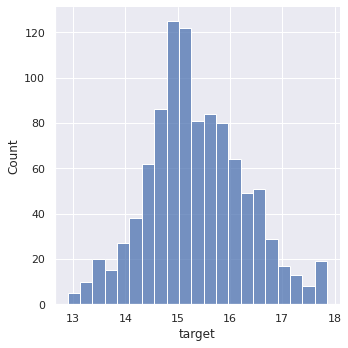

In [32]:
sns.displot(target_clean)

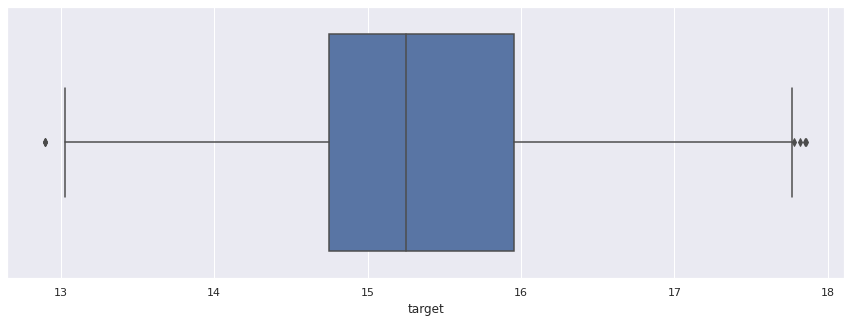

In [34]:
plt.figure(figsize = (15, 5))
sns.boxplot(x=target_clean)

In [35]:
train_clean = train[target_clean_mask]
train_outlier = train[~target_clean_mask]

print('정제된 데이터의 수 : ', len(train_clean))
print('이상치의 수 : ', len(train_outlier))

정제된 데이터의 수 :  1005
이상치의 수 :  10


## 수치형 데이터 분석
- 카테고리(분류)형 변수 반대이다
- 수치형 데이터는 연속형(실수)와 이산형(정수)로 나뉜다.
- 주행거리가 연속형이고, 제조년도가 이산형이 된다.

In [36]:
# 수치형변수 불러오기
odometer = train_clean.odometer
year = train_clean.year

### 주행거리 분석

<Figure size 1440x360 with 0 Axes>

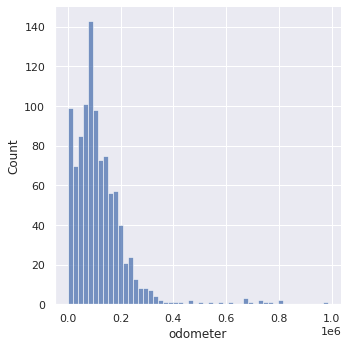

In [37]:
# 주행거리도 보면 이상치가 좀 있네.. 상당히 많이 주행한 차들
plt.figure(figsize = (20, 5))
sns.displot(odometer)

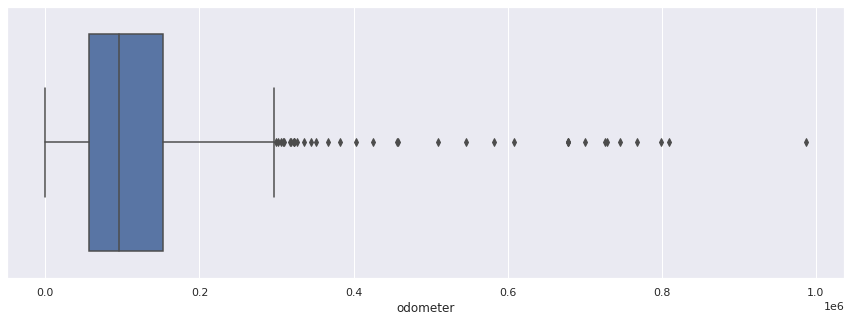

In [38]:
# 신기한건 주행거리가 0인 매물도 있는거 같다. 실제 0인 미개봉중고인지 아니면 주행거리 측정오류로 0이 된건지는 모르겠음. 
# 어찌됐건 0인 매물도 이상치로 보는게 좋을듯하다
plt.figure(figsize = (15, 5))
sns.boxplot(x=odometer)

In [39]:
len(train_clean[odometer == 0])

21

### 제작년도 분석

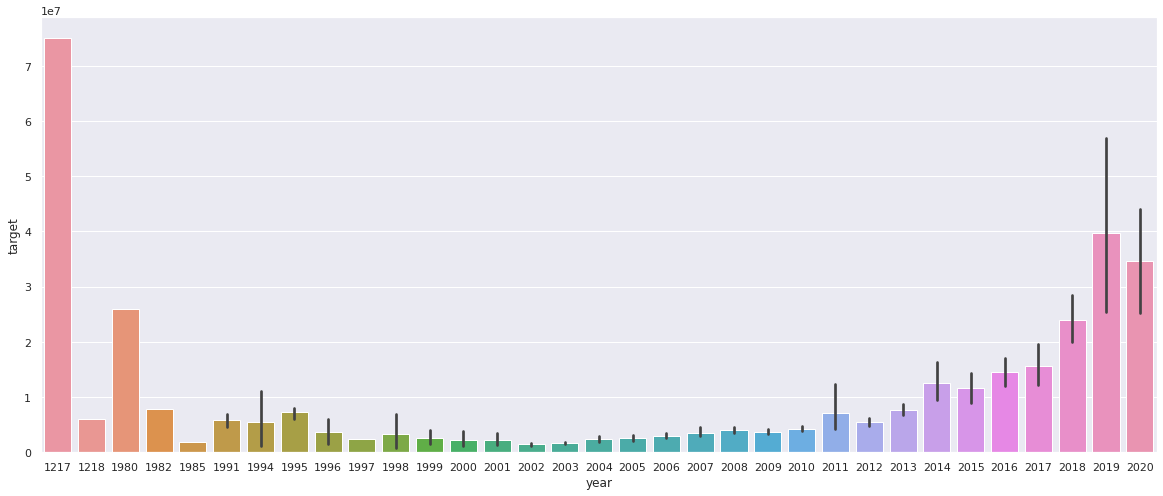

In [45]:
# 제작년도는 거의 분류형이라고 봐도 무방할듯
# 제작년도별 타겟값을 그래프로 나타내봤는데 역시 최신 모델이 비싸게 거래되는 걸 알 수 있음
# 근데 뜬금없이 1217, 1218 이란 이상한 년도가 있음. 이건 제거해줘야겠음
sns.barplot(x='year', y='target', data=train)

In [41]:
train_clean = train_clean[year > 1218]

### 타겟값과의 상관관계 분석

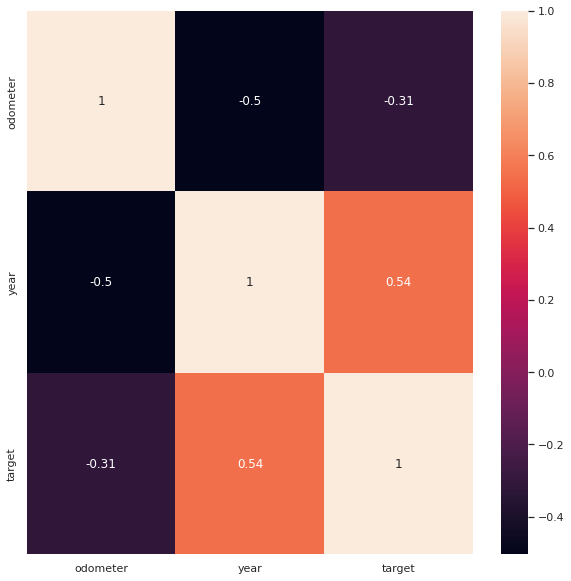

In [53]:
# 상관관계를 보면 주행거리와 가격은 음의 관계(반비례), 제작년도와 가격은 양의 관계(비례)를 보이는 것을 알 수 있음
corrMat = train_clean[['odometer', 'year', 'target']].corr()
plt.figure(figsize = (10, 10))
sns.heatmap(corrMat, annot=True)

## 분류형 데이터 분석